In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pprint
from typing import Dict, Sequence

import numpy
import pandas
# import napari
import seaborn
import torch
from imageio import imread
from ruamel.yaml import YAML
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

from hylfm.eval.metrics import compute_metrics_individually, init_metrics
yaml = YAML(typ="safe")

/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/hylfm/_settings/default.py:76: UserWarning: numpy imported before hylfm. numpy env var settings won't take effect!
  warnings.warn("numpy imported before hylfm. numpy env var settings won't take effect!")


In [2]:
def get_validate_df(name, step_dirs, z_mod):
    metrics_config = yaml.load(Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/configs/metrics/heart_dynamic.yml"))
    metrics_instances = init_metrics(metrics_config)

    all_preds = []
    all_ls_slices = []
    pred_nrs = []
    for step_dir in tqdm(step_dirs, desc=f"load raw data for {name}"):
        assert step_dir.name == "run000"
        pred_nr = int(step_dir.parent.name.split("_")[-1])
        pred_nrs.append(pred_nr)
        ls_slices = numpy.stack([imread(p) for p in sorted(step_dir.glob("ds0-0/ls_slice/*.tif"))])
        assert (ls_slices.shape[0] % z_mod) == 0
        all_ls_slices.append(ls_slices)
        preds = numpy.stack([imread(p) for p in sorted(step_dir.glob("ds0-0/pred/*.tif"))])
        assert preds.shape == ls_slices.shape, (preds.shape, ls_slices.shape)
        all_preds.append(preds)

    data = None
    for pred_nr, preds, ls_slices in tqdm(zip(pred_nrs, all_preds, all_ls_slices), total=len(all_preds), desc=f"comp. metrics for {name}"):
        step = 0
        for idx, (pred, ls_slice) in enumerate(zip(preds, ls_slices)):
            # add batch and channel dim
            pred = pred[None, None]
            ls_slice = ls_slice[None, None]

            tensors = {"pred": torch.from_numpy(pred), "ls_slice": torch.from_numpy(ls_slice)}
            computed_metrics = {k: m.value for k, m in compute_metrics_individually(metrics_instances, tensors).items()}
            computed_metrics["idx"] = idx
            computed_metrics["pred_nr"] = pred_nr
            if data is None:
                data = {k: [v] for k, v in computed_metrics.items()}
            else:
                for mk, mv in computed_metrics.items():
                    data[mk].append(mv)

    df = pandas.DataFrame.from_dict(data)
    df["swipe_through"] = df["pred_nr"]
    df["pred_nr"] = 0
    return df

def get_refine_ls_slices(z_mod, fish2: bool):
    if fish2:
#         ls_dir = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/validate_fish2/from_static_heart/20-11-12_15-11-48/test_dynamic_00/run000")
        ls_dir = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/validate_fish2/from_static_heart/20-11-13_14-25-29/test_dynamic_00/run000")
    else:
        ls_dir = Path(
            "/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/train/heart/z_out49/dualview_single_lfm_static_f4_center49/20-11-09_18-09-02/validate_train_01/run000"
        )

    ls_slices = numpy.stack([imread(p) for p in sorted(ls_dir.glob("ds0-0/ls_slice/*.tif"))])
    assert (ls_slices.shape[0] % z_mod) == 0, (ls_slices.shape[0], z_mod)
    return ls_slices



def get_refine_df(name, step_dirs, z_mod, ls_slices):
    assert (ls_slices.shape[0] % z_mod) == 0, (ls_slices.shape[0], z_mod)

    metrics_config = yaml.load(Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/configs/metrics/heart_dynamic.yml"))
    metrics_instances = init_metrics(metrics_config)

    all_preds = []
    pred_nrs = []
    for step_dir in tqdm(step_dirs, desc=f"load raw data for ls_slices"):
        assert step_dir.name.startswith("run")
        pred_nr = int(step_dir.name.replace("run", ""))
        pred_nrs.append(pred_nr)

        preds = numpy.stack([imread(p) for p in sorted(step_dir.glob("ds0-0/pred/*.tif"))])
        assert preds.shape == ls_slices.shape, (preds.shape, ls_slices.shape)
        all_preds.append(preds)

    data = None
    for pred_nr, preds in zip(tqdm(pred_nrs, desc=f"comp. metrics for {name}"), all_preds):
        for idx, (pred, ls_slice) in enumerate(zip(preds, ls_slices)):
            # add batch and channel dim
            pred = pred[None, None]
            ls_slice = ls_slice[None, None]

            tensors = {"pred": torch.from_numpy(pred), "ls_slice": torch.from_numpy(ls_slice)}
            computed_metrics = {k: m.value for k, m in compute_metrics_individually(metrics_instances, tensors).items()}
            computed_metrics["idx"] = idx
            computed_metrics["pred_nr"] = pred_nr
            if data is None:
                data = {k: [v] for k, v in computed_metrics.items()}
            else:
                for mk, mv in computed_metrics.items():
                    data[mk].append(mv)

    df = pandas.DataFrame.from_dict(data)
    df["swipe_through"] = df["idx"] // z_mod
    return df

def get_df(name, *, pred_nrs = (0,), ls_slices: Dict[int, numpy.ndarray]):
    if name == "validate_from_static_heart":
        root = Path(
            # "/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/z_out49/contin_validate_f4/20-11-10_14-02-53"
            "/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/z_out49/contin_validate_f4/20-11-11_19-35-43"
#             "/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/z_out49/contin_validate_f4/20-11-13_13-53-21" ??
        )

        assert root.exists(), root
        z_min = 29
        z_mod = 189
        step_dirs = sorted(root.glob("test_dynamic_*/run000"))
    elif name == "validate_fish2/from_static_heart":
        # /g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/validate_fish2/from_static_heart/20-11-12_15-11-48
        root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/validate_fish2/from_static_heart/20-11-13_14-25-29")
        z_min = 19
        z_mod = 209
        step_dirs = [root / "test_dynamic_00/run000"]
    elif name.startswith("refine_fish2/"):
        map_name_here = name[len("refine_fish2/"):]
        z_min = 29
        z_mod = 189
        common_root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/train/heart/")
        names_map = {}
        times_map = {
            "from_bad_static_heart": "20-11-12_15-45-00",
            # "from_heart_lr": "20-11-12_15-42-08",
            "from_heart_lr": "20-11-12_17-08-03",
            # "from_medium_beads": "20-11-12_15-42-08",
            "from_medium_beads": "20-11-12_17-08-03",
            # "from_mednlarge_beads": "20-11-12_15-15-55",
            # "from_mednlarge_beads": "20-11-12_15-40-40",
            "from_mednlarge_beads": "20-11-12_17-07-40",
            # "from_static_heart": "20-11-12_15-42-07",
            "from_static_heart": "20-11-12_17-08-02",
         }
        root = common_root / names_map.get(map_name_here, name) / times_map[map_name_here]
        assert root.exists(), root
        step_dirs = sorted(root.glob("validate_train_01/run*"))[:-1]
    elif name.startswith("refine_from"):
        z_min = 29
        z_mod = 189
        common_root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/train/heart/z_out49/")
        names_map = {"refine_from_lfd_heart": "dualview_single_lfm_static_f4_center49"}
        times_map = {
            "refine_from_bad_static_heart": "20-11-11_20-00-16",
            "refine_from_lfd_heart": "20-11-09_18-09-02",
            "refine_from_medium_beads": "20-11-11_13-09-30",
            "refine_from_mednlarge_beads": "20-11-11_19-55-02",
            "refine_from_static_heart": "20-11-11_19-48-09",
        }
        root = common_root / names_map.get(name, name) / times_map[name]
        assert root.exists(), root
        step_dirs = sorted(root.glob("validate_train_01/run*"))[:-1]
    else:
        raise NotImplementedError(name)

    if name.startswith("validate_from"):
        # if "from_static" in name:
        #     def idx2z(idx):
        #         return z_min + (idx % z_mod)
        # else:
        #     raise NotImplementedError(name)
        _get_df = get_validate_df
#         step_dirs = step_dirs[:4]
        get_df_kwargs = {}
    elif name.startswith("refine") or name.startswith("validate_fish2"):
        _get_df = get_refine_df
        step_dirs = numpy.asarray(step_dirs)[pred_nrs]

        if (z_mod, "fish2" in name) not in ls_slices:
            ls_slices[z_mod] = get_refine_ls_slices(z_mod, "fish2" in name)

        get_df_kwargs = {"ls_slices": ls_slices[z_mod]}
    else:
        raise NotImplementedError(name)

    def idx2z(idx):
        return z_min + z_mod - 1 - (idx % z_mod)

    df = _get_df(name, step_dirs, z_mod, **get_df_kwargs)
    df["z"] = df["idx"].apply(idx2z) - 120
    df["frame"] = df["swipe_through"] * 241 + 120 - df["z"]
    df["time [s]"] = df["frame"] * 0.025
    df["run_name"] = name
    return df

def add_df(df, name, pred_nrs, ls_slices):
    dfs = [df, get_df(name, pred_nrs=pred_nrs, ls_slices=ls_slices)]
    return pandas.concat(dfs)

def get_dfs(*names, pred_nrs):
    dfs = []
    ls_slices = {}
    for name in names:
        dfs.append(get_df(name, pred_nrs=pred_nrs, ls_slices=ls_slices))

    return pandas.concat(dfs), ls_slices

In [3]:
validate_df, validate_ls_slices = get_dfs("validate_fish2/from_static_heart", pred_nrs=[0])

load raw data for ls_slices: 100%|██████████| 1/1 [01:06<00:00, 66.43s/it]
comp. metrics for validate_fish2/from_static_heart: 100%|██████████| 1/1 [31:06<00:00, 1866.10s/it]


In [4]:
filtered_validate_df = validate_df 
# filtered_validate_df = validate_df[(validate_df.z <= 98) & (validate_df.z >= -85)]
filtered_validate_df.head()

,smooth_l1_loss-scaled,ms_ssim-scaled,ssim-scaled,nrmse-scaled,psnr-scaled,mse_loss-scaled,idx,pred_nr,swipe_through,z,frame,time [s],run_name
0,0.000016,0.985851,0.900886,0.836704,44.949522,0.000032,0,0,0,107,13,0.325,validate_fish2/from_static_heart
1,0.000015,0.985179,0.903280,0.834820,45.175433,0.000030,1,0,0,106,14,0.350,validate_fish2/from_static_heart
2,0.000028,0.959907,0.879654,0.876541,42.513771,0.000056,2,0,0,105,15,0.375,validate_fish2/from_static_heart
3,0.000078,0.918160,0.837280,0.927081,38.064866,0.000156,3,0,0,104,16,0.400,validate_fish2/from_static_heart
4,0.000167,0.880630,0.786959,0.951193,34.772949,0.000333,4,0,0,103,17,0.425,validate_fish2/from_static_heart


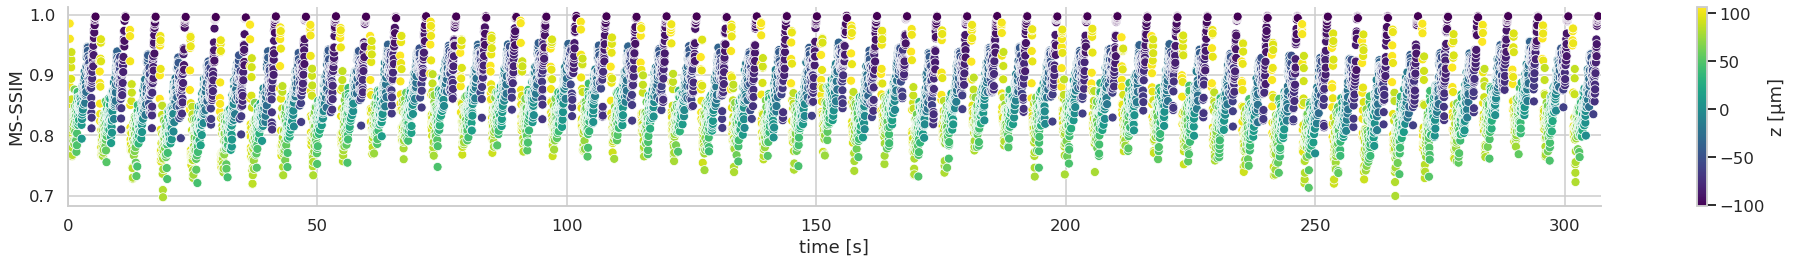

In [79]:
plt.rcParams['svg.fonttype'] = 'none'
def plot_conti_vali(metric: str):
    seaborn.set_style("whitegrid")#, {"axes.facecolor": ".8"})
    seaborn.set_context("talk")  # paper, notebook, talk, poster
    cmap_name = "viridis"  # viridis, magma, cividis, plasma
    g = seaborn.relplot(
        x="time [s]",
        y=metric,
        hue="z",
        legend=False,  # False, "brief", "full"
#         row="pred_nr",
#         col="swipe_through",
#         palette=cmap_name,
#         palette = ["#FFB000"], # [(1., 176/255, 0.)],   #FFB000, #FE6100, #DC267F, #785EF0 #648FFF
        palette = cmap_name,
        height=4, aspect=7,
        kind="scatter",
        data=filtered_validate_df,
    )
#     g.map(plt.axvline, x=25, color=".7", dashes=(2, 1), zorder=0)
    g.set_axis_labels("time [s]", "MS-SSIM")
#     g.set_titles("training step: {row_name}")
#     ax = g.axes[0][0]
#     y_twin = ax.twiny()
#     y_twin.set_xlim(ax.get_ylim())
# #         y_twin.set_xticklabels(np.round(ax.get_xticks()/scale,1))
#     y_twin.set_xlabel('z')
    # g.add_legend()
    
    cbar = g.fig.colorbar(
      matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=filtered_validate_df["z"].min(), vmax=filtered_validate_df["z"].max(), clip=False), cmap=cmap_name), label='z [μm]',
#       ticks=[filtered_validate_df.z.min(), -50, 0, 50, filtered_validate_df.z.max()]
    )
#     cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
    #         ax.set_xlim([-z_range_value * 1.1, z_range_value * 1.1])
#         ax.set_ylim([-z_range_value * 1.1, z_range_value * 1.1])
#         ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
#     g.fig.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=z_offset, vmax=df["z"].max()+z_offset, clip=False), cmap=cmap_name), label='z')
    g.fig.axes[0].set_xlim(0, 12291*0.025)
#     g.fig.axes[0].set_xlim(-100, 100)
#     g.fig.tight_layout()
#     g.add_legend()
    root = Path("plot_conti_vali")
    root.mkdir(exist_ok=True)
    g.fig.savefig(root / f"{metric}.svg")

    return g

g = plot_conti_vali("ms_ssim-scaled")


In [56]:
filtered_validate_df_selection = validate_df[(validate_df.swipe_through == 0) | (validate_df.swipe_through == 1) | (validate_df.swipe_through == 25) | (validate_df.swipe_through == 26) | (validate_df.swipe_through == 49) | (validate_df.swipe_through == 50)]

filtered_validate_df_selection["time_group"] = filtered_validate_df_selection["swipe_through"]
filtered_validate_df_selection.loc[filtered_validate_df_selection.time_group == 1, "time_group"] = 0
filtered_validate_df_selection.loc[filtered_validate_df_selection.time_group == 26, "time_group"] = 25
filtered_validate_df_selection.loc[filtered_validate_df_selection.time_group == 50, "time_group"] = 49
filtered_validate_df_selection[filtered_validate_df_selection.time_group == 25]

/home/beuttenm/miniconda3/envs/hylfm/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/beuttenm/miniconda3/envs/hylfm/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/beuttenm/miniconda3/envs/hylfm/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is tryi

,smooth_l1_loss-scaled,ms_ssim-scaled,ssim-scaled,nrmse-scaled,psnr-scaled,mse_loss-scaled,idx,pred_nr,swipe_through,z,frame,time [s],run_name,time_group
5225,0.000035,0.952049,0.867475,0.904375,41.585555,0.000069,5225,0,25,107,6038,150.950,validate_fish2/from_static_heart,25
5226,0.000056,0.933242,0.841225,0.922900,39.489987,0.000112,5226,0,25,106,6039,150.975,validate_fish2/from_static_heart,25
5227,0.000097,0.891894,0.813204,0.947834,37.142200,0.000193,5227,0,25,105,6040,151.000,validate_fish2/from_static_heart,25
5228,0.000122,0.880505,0.777956,0.955421,36.108706,0.000245,5228,0,25,104,6041,151.025,validate_fish2/from_static_heart,25
5229,0.000185,0.866897,0.763933,0.947960,34.329195,0.000369,5229,0,25,103,6042,151.050,validate_fish2/from_static_heart,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,0.000002,0.996485,0.978757,0.918320,55.126443,0.000003,5638,0,26,-97,6483,162.075,validate_fish2/from_static_heart,25
5639,0.000001,0.996778,0.980666,0.937200,55.791540,0.000003,5639,0,26,-98,6484,162.100,validate_fish2/from_static_heart,25
5640,0.000001,0.996899,0.980438,0.945091,55.846581,0.000003,5640,0,26,-99,6485,162.125,validate_fish2/from_static_heart,25
5641,0.000001,0.997252,0.980823,0.924159,55.886936,0.000003,5641,0,26,-100,6486,162.150,validate_fish2/from_static_heart,25


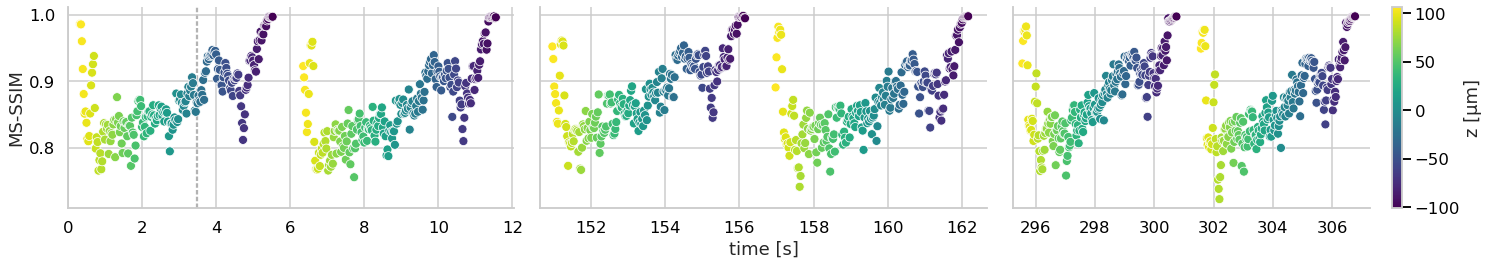

In [80]:
def plot_conti_vali_selection(metric: str):
    plt.rcParams['svg.fonttype'] = 'none'
    seaborn.set_style(
        "whitegrid",         
        {
            'xtick.color': '0',
            'ytick.color': '0',
        }
    )#, {"axes.facecolor": ".8"})
    seaborn.set_context("talk")  # paper, notebook, talk, poster
    cmap_name = "viridis"  # viridis, magma, cividis, plasma
    g = seaborn.relplot(
        x="time [s]",
        y=metric,
        hue="z",
        legend=False,  # False, "brief", "full"
#         row="pred_nr",
        col="time_group",
#         palette=cmap_name,
#         palette = ["#FFB000"], # [(1., 176/255, 0.)],   #FFB000, #FE6100, #DC267F, #785EF0 #648FFF
        palette = cmap_name,
        height=4, aspect=1.7,
        kind="scatter",
        data=filtered_validate_df_selection,
        facet_kws={"sharex":False},
    )
    g.map(plt.axvline, x=(120+19)*0.025, color=".7", dashes=(2, 1), zorder=0)
    g.set_axis_labels("time [s]", "MS-SSIM")
#     g.set_titles("training step: {row_name}")
#     ax = g.axes[0][0]
#     y_twin = ax.twiny()
#     y_twin.set_xlim(ax.get_ylim())
# #         y_twin.set_xticklabels(np.round(ax.get_xticks()/scale,1))
#     y_twin.set_xlabel('z')
    # g.add_legend()
    cbar = g.fig.colorbar(
      matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=filtered_validate_df["z"].min(), vmax=filtered_validate_df["z"].max(), clip=False), cmap=cmap_name), label='z [μm]',
#       ticks=[filtered_validate_df.z.min(), -50, 0, 50, filtered_validate_df.z.max()]
    )
#     cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
    #         ax.set_xlim([-z_range_value * 1.1, z_range_value * 1.1])
#         ax.set_ylim([-z_range_value * 1.1, z_range_value * 1.1])
#         ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
#     g.fig.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=z_offset, vmax=df["z"].max()+z_offset, clip=False), cmap=cmap_name), label='z')
    g.set_titles("") #col_template="{col_name}", row_template="refinement iterations: {row_name}")
    g.fig.axes[0].set_xlim(0, 241*2*0.025)
    g.fig.axes[1].set_xlim(241*25*0.025, 241*27*0.025)
    g.fig.axes[2].set_xlim(241*49*0.025, 241*51*0.025)
    g.fig.axes[0].set_xlabel('')
    g.fig.axes[2].set_xlabel('')
    
#     g.fig.axes[0].set_xlim(-100, 100)
#     g.fig.tight_layout()
#     g.add_legend()
    root = Path("plot_conti_vali_selection")
    root.mkdir(exist_ok=True)
    g.fig.savefig(root / f"{metric}.svg")
    return g

g = plot_conti_vali_selection("ms_ssim-scaled")

In [62]:
seaborn.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.8',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '0',
 'ytick.color': '0',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}